In [1]:
# 数据接口 
import akshare as ak
import baostock as bs
import tushare as ts

# 基础模块
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 回测框架
import backtrader as bt

### 基础函数

In [66]:
#s_date = (datetime.datetime.now() - datetime.timedelta(days = 365))
#e_date = datetime.datetime.now()

def get_data_fut(token, stock_code, s_date, e_date):
    ts.set_token(token)
    pro = ts.pro_api()
    df = pro.fut_daily(ts_code=stock_code, 
                       fields='trade_date,open,high,low,close,vol',
                       start_date=s_date.strftime('%Y%m%d'), end_date=e_date.strftime('%Y%m%d'))
    df.index=pd.to_datetime(df.trade_date)
    df.drop('trade_date', axis=1, inplace = True)
    df = df.astype('float')
    df.rename(columns = {'vol':'volume'}, inplace = True)
    df['openinterest'] = 0
    return df.iloc[::-1]

def get_data_index(stock_code, s_date, e_date):
    lg = bs.login()
    rs = bs.query_history_k_data_plus('sz.300661', 'date,open,high,low,close,volume', 
                                      start_date=s_date.strftime('%Y-%m-%d'), 
                                      end_date=e_date.strftime('%Y-%m-%d'), 
                                      frequency="d")
    result = pd.DataFrame(columns=['date','open','high','low','close','volume'])
    i = 0
    while (rs.error_code == '0') & rs.next():
        result.loc[i, ] = rs.get_row_data()
        i += 1
    result.index=pd.to_datetime(result.date)
    result.drop('date', axis=1, inplace = True)
    result = result.astype('float')
    result['openinterest'] = 0
    bs.logout()
    return result

### 策略

In [17]:
class ATRStrategy_1(bt.Strategy):
    params = (
        ('printlog', False),
        ('initial', 10000),
        ('atr_period', 14),
        ('atr_percent', 1),
        ('atr_risk', 1),
        ('b_per', 20),
        ('b_dev', 2),
    )
    
    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s: %s' % (dt.isoformat(), txt))
        
    def __init__(self):
        # Keep references to the "close, high, low" lines in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low

        # To keep track of pending orders and buy price/commission
        self.order = None
        #self.buyprice = None
        #self.buycomm = None
        #self.sellprice = None
        #self.sellcomm = None
        self.openpos = False
        self.openprice = 0
        
        # Adding an ATR indicator
        self.tr = bt.indicators.Max((self.datahigh - self.datalow), 
                                                         abs(self.dataclose(-1) - self.datahigh),
                                                         abs(self.dataclose(-1) - self.datalow))
        self.atr = bt.indicators.SimpleMovingAverage(self.tr, period=self.params.atr_period)
        
        # Add Bollinger Bands indicator
        self.lines.top = bt.indicators.BollingerBands(self.datas[0], 
                                                      period = self.params.b_per, 
                                                      devfactor = self.params.b_dev).top
        self.lines.bot = bt.indicators.BollingerBands(self.datas[0], 
                                                      period = self.params.b_per, 
                                                      devfactor = self.params.b_dev).bot

        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                
                self.log('BUY EXECUTED, Price: %.2f, Lot:%i, Position:%i, Cash: %i, Value: %i' %
                         (order.executed.price,
                          order.executed.size,
                          self.getposition(data).size,
                          self.broker.get_cash(),
                          self.broker.get_value()))
                
                if self.openpos:
                    self.openprice = order.executed.price
                    self.openpos = False
                    
                #self.buyprice = order.executed.price
                #self.buycomm = order.executed.comm
                
            else:  # Sell

                self.log('SELL EXECUTED, Price: %.2f, Lot:%i, Position:%i, Cash: %i, Value: %i' %
                         (order.executed.price,
                          -order.executed.size,
                          self.getposition(data).size,
                          self.broker.get_cash(),
                          self.broker.get_value()))

                if self.openpos:
                    self.openprice = order.executed.price
                    self.openpos = False
                    
                #self.sellprice = order.executed.price
                #self.sellcomm = order.executed.comm
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
        
    def next(self):
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        
        # Close a position
#        if self.getposition(data).size != 0 and (self.datalow < self.openprice - self.params.atr_risk * self.atr[0] or self.datahigh > self.openprice + self.params.atr_risk * self.atr[0]):
#            p = self.datalow[0] if self.datalow < self.openprice - self.params.atr_risk * self.atr[0] else self.datahigh[0]
#            if self.getposition(data).size > 0:
#                self.log('SELL CREATE(Close position), Price: %.2f, Lots: %i' % (p, self.getposition(data).size))
#                self.order = self.sell(size = self.getposition(data).size)
#            elif self.getposition(data).size < 0:
#                self.log('Buy CREATE(Close position), Price: %.2f, Lots: %i' % (p, -self.getposition(data).size))
#                self.order = self.buy(size = self.getposition(data).size)                
           
        # Bollinger Bands Buy Singal
        if (self.dataclose[0] > self.lines.top[0] and self.dataclose[-1] < self.lines.top[-1]) or (self.dataclose[0] > self.lines.bot[0] and self.dataclose[-1] < self.lines.bot[-1]):
                opt_position = np.round(self.params.initial * self.params.atr_percent / 100 / self.atr[0])
                
                if opt_position > self.getposition(data).size:
                    
                    # Opening position
                    if self.getposition(data).size == 0:
                        self.openpos = True
                    
                    self.log('BUY CREATE, Price: %.2f, Lots: %i, ATR: %.2f' % (self.dataclose[0], opt_position - self.getposition(data).size, self.atr[0]))
            
                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.buy(size = opt_position - self.getposition(data).size)
                
                elif opt_position < self.getposition(data).size:
                    
                    self.log('SELL CREATE, Price: %.2f, Lots: %i, ATR: %.2f' % (self.dataclose[0], self.getposition(data).size - opt_position, self.atr[0]))
                    
                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.sell(size = self.getposition(data).size - opt_position)                    

        # Bollinger Bands Sell Singal
        elif  (self.dataclose[0] < self.lines.top[0] and self.dataclose[-1] > self.lines.top[-1]) or (self.dataclose[0] < self.lines.bot[0] and self.dataclose[-1] > self.lines.bot[-1]):
                opt_position = np.round(self.params.initial * self.params.atr_percent / 100 / self.atr[0])

                    
                if -opt_position < self.getposition(data).size:
                                        
                    # Opening position
                    if self.getposition(data).size == 0:
                        self.openpos = True                    

                    self.log('SELL CREATE, Price: %.2f, Lots: %i, ATR: %.2f' % (self.dataclose[0], opt_position + self.getposition(data).size, self.atr[0]))
                    
                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.sell(size = opt_position + self.getposition(data).size)
                
                elif -opt_position > self.getposition(data).size:

                    self.log('BUY CREATE, Price: %.2f, Lots: %i, ATR: %.2f' % (self.dataclose[0], -self.getposition(data).size - opt_position, self.atr[0]))
                    
                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.buy(size = -self.getposition(data).size - opt_position)                    
                    

             
    def stop(self):
        self.log('Ending Position %i. Ending Value %.2f, Net Profit: %.2f%%, (%i, %.1f)' %
                 (self.getposition(data).size, self.broker.getvalue(), (self.broker.getvalue() / self.params.initial - 1) * 100, self.params.atr_period, self.params.atr_percent), doprint = True)

### 策略细节
1. 由下向上突破布林带上界和下界时买入。
2. 由上向下突破布林带上界和下界时卖出。
3. 每次买入和卖出时根据海龟ATR模型计算手数，若开仓直接买入最优化手数，若加仓/反向开仓则调整至最优持有手数。

### 回测

In [4]:
s_date = (datetime.datetime.now() - datetime.timedelta(days = 365))
e_date = datetime.datetime.now()
df = get_data_fut('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6', 'IFL.CFX', s_date, e_date)

In [ ]:
if __name__ ==  '__main__':
    max_np = 0.0
    max_idx = (0, 0.0)
    for i in range(3, 21, 1):
        for j in np.arange(0.2, 2.1, 0.1):
            # Create a cerebro entity
            cerebro = bt.Cerebro()

            # Add a strategy
            strats = cerebro.addstrategy(ATRStrategy_1, printlog = False, initial = 100000,  
                                         b_per = 21, b_dev = 2, atr_period = i, atr_percent = float(j)) 


            # Create a Data Feed
            data = bt.feeds.PandasData(dataname=df,fromdate=s_date,todate=e_date)


            # Set cash inside the strategy
            cerebro.broker = bt.brokers.BackBroker(coc=True)   
            cerebro.broker.setcash(100000)

            # Add the Data Feed to Cerebo
            cerebro.adddata(data)

            # Set leverage
            cerebro.broker.setcommission(mult = 10)

            # Print out the starting conditions
            start_value = cerebro.broker.getvalue()
            #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

            # Run over everything
            cerebro.run()

            # Print out the final result
            final_value = cerebro.broker.getvalue()
            netp = (final_value / start_value -1)*100
            if netp > max_np:
                max_np = netp
                max_idx = (i, j)
print(max_np, max_idx)

### 最优参数运行结果

布林带周期：21

布林带波动乘数：2

ATR计算周期：3

ATR1%波动对应资金百分比(%)：2

最终收益率：117.81%

In [16]:
 # Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
strats = cerebro.addstrategy(ATRStrategy_1, printlog = True, initial = 100000,  
                             b_per =21, b_dev = 2, atr_period = 3, atr_percent = 2) 


# Create a Data Feed
data = bt.feeds.PandasData(dataname=df,fromdate=s_date,todate=e_date)


# Set cash inside the strategy
cerebro.broker = bt.brokers.BackBroker(coc=True)   
cerebro.broker.setcash(100000)

# Add the Data Feed to Cerebo
cerebro.adddata(data)

# Set leverage
cerebro.broker.setcommission(mult = 10)

# Print out the starting conditions
start_value = cerebro.broker.getvalue()
#print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
final_value = cerebro.broker.getvalue()
netp = (final_value / start_value -1)*100

2021-11-03: SELL CREATE, Price: 4816.40, Lots: 25, ATR: 80.20
2021-11-04: SELL EXECUTED, Price: 4816.40, Lot:25, Position:-25, Cash: 220410, Value: 98819
2021-11-04: BUY CREATE, Price: 4863.60, Lots: 49, ATR: 83.93
2021-11-05: Order Canceled/Margin/Rejected
2021-12-08: BUY CREATE, Price: 5005.80, Lots: 58, ATR: 61.00
2021-12-09: Order Canceled/Margin/Rejected
2021-12-14: SELL CREATE, Price: 5059.40, Lots: 12, ATR: 54.33
2021-12-15: SELL EXECUTED, Price: 5059.40, Lot:12, Position:-37, Cash: 281122, Value: 95782
2022-01-06: BUY CREATE, Price: 4818.20, Lots: 14, ATR: 85.73
2022-01-07: BUY EXECUTED, Price: 4818.20, Lot:14, Position:-23, Cash: 223371, Value: 112290
2022-01-07: BUY CREATE, Price: 4829.60, Lots: 52, ATR: 69.53
2022-01-10: Order Canceled/Margin/Rejected
2022-01-13: SELL CREATE, Price: 4767.20, Lots: 3, ATR: 77.73
2022-01-14: SELL EXECUTED, Price: 4767.20, Lot:3, Position:-26, Cash: 237672, Value: 114859
2022-01-17: BUY CREATE, Price: 4763.60, Lots: 54, ATR: 71.20
2022-01-18: O

<IPython.core.display.Javascript object>


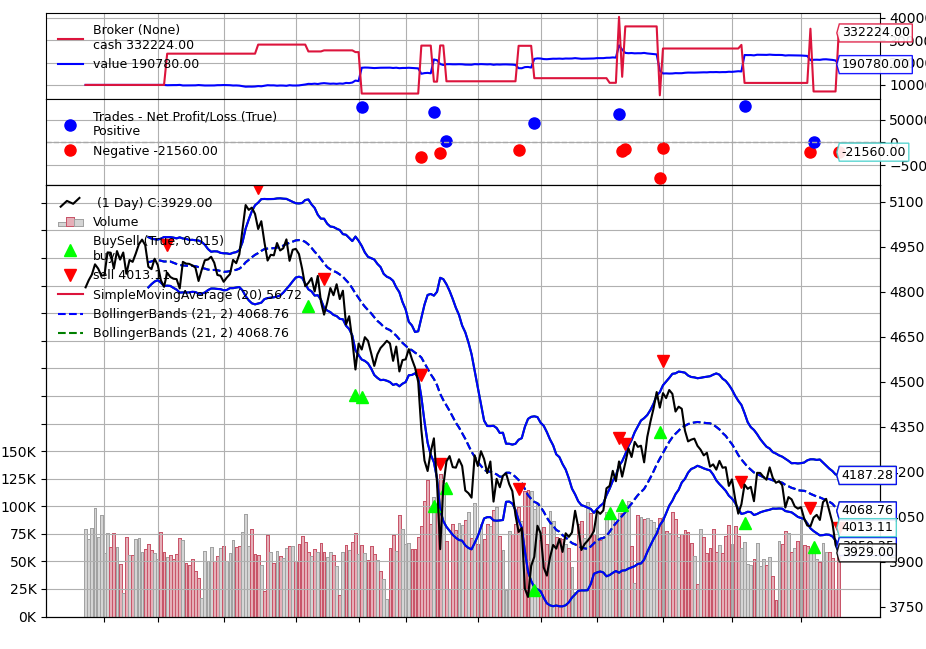

[[<Figure size 640x480 with 4 Axes>]]

In [20]:
cerebro.plot()